<div class="alert alert-block alert-info">
    <img style="float: right;" src="./material/OSE.svg" width="50">
    <u><h1>The Career Decisions of Young Men</h1></u>
</div>

This notebook processes and explores the estimation sample used by Michael Keane and Kenneth Wolpin to study the career decisions of young men. 

> Keane, M. P. and Wolpin, K. I. (1997). [The career decisions of young men](http://www.journals.uchicago.edu/doi/10.1086/262080). *Journal of Political Economy*, 105(3), 473-522.

The sample is based on the [National Longitudinal Survey of Youth 1979 (NLSY79)](https://www.bls.gov/nls/nlsy79.htm) which is available to download [here](https://github.com/structDataset/career_decisions_data/blob/master/KW_97.raw). 

<div class="alert alert-block alert-info">
    <h3>Preparations</h3>
</div>

We first peform some basic preparations to ease further processing.

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display_html

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)

<IPython.core.display.Javascript object>

In [3]:
# Proper formatting of the wage variable.
pd.options.display.float_format = "{:,.2f}".format

# Label and format columns
columns = ["Identifier", "Age", "schooling_experience", "Choice", "Wage"]
dtype = {
    "Identifier": np.int,
    "Age": np.int64,
    "schooling_experience": np.int,
    "Choice": "category",
}

# Read the original data file
df = pd.DataFrame(np.genfromtxt("KW_97.raw"), columns=columns).astype(dtype)

<IPython.core.display.Javascript object>

In [4]:
# Labeling different choice categories, introduction period, setting index
df["Choice"] = df["Choice"].map(
    {
        1.0: "schooling",
        2.0: "home",
        3.0: "white_collar",
        4.0: "blue_collar",
        5.0: "military",
    }
)
df["Period"] = df["Age"] - 16
df.set_index(["Identifier", "Period"], inplace=True, drop=True)

<IPython.core.display.Javascript object>

In [5]:
def get_working_experience(agent):
    """This function generates the work experience in the three occupations that an individual prior to a given year"""

    for occupation in ["blue_collar", "white_collar", "military"]:
        agent[f"{occupation}_experience"] = (
            (agent["Choice"] == occupation).astype(int).cumsum().shift(1)
        )
    return agent

<IPython.core.display.Javascript object>

In [6]:
df = df.groupby("Identifier").apply(lambda x: get_working_experience(x))

<IPython.core.display.Javascript object>

<div class="alert alert-block alert-info">
    <h3>Basic Structure</h3>
</div>



First we explore the basic structure of the dataset. All individuals enter the model initially at the same age and are then observed for a varying number of consecutive years. Each year, the individual's decision to work in either a white or blue collar occupation, attend school, enroll in the miliary, or remain at home is recorded. If working, the dataset potentially also contains that year's wage as a full-time equivalent.

In [7]:
df.head(15)

Age  schooling_experience        Choice      Wage  \
Identifier Period                                                      
6          0        16                    11     schooling       nan   
           1        17                    12     schooling       nan   
           2        18                    13     schooling       nan   
           3        19                    14     schooling       nan   
           4        20                    15     schooling       nan   
           5        21                    16          home       nan   
           6        22                    16  white_collar 14,062.67   
           7        23                    16  white_collar 15,921.17   
           8        24                    16  white_collar 18,602.73   
           9        25                    16  white_collar 19,693.95   
           10       26                    16  white_collar 20,611.00   
7          0        16                    10     schooling       nan   
           1        17                    11     schooling       nan   
           2        18                    12   blue_collar 18,795.29   
           3        19                    12      military  9,647.86   

                   blue_collar_experience  white_collar_experience  \
Identifier Period                                                    
6          0                          nan                      nan   
           1                         0.00                     0.00   
           2                         0.00                     0.00   
           3                         0.00                     0.00   
           4                         0.00                     0.00   
           5                         0.00                     0.00   
           6                         0.00                     0.00   
           7                         0.00                     1.00   
           8                         0.00                     2.00   
           9                         0.00                     3.00   
           10                        0.00                     4.00   
7          0                          nan                      nan   
           1                         0.00                     0.00   
           2                         0.00                     0.00   
           3                         1.00                     0.00   

                   military_experience  
Identifier Period                       
6          0                       nan  
           1                      0.00  
           2                      0.00  
           3                      0.00  
           4                      0.00  
           5                      0.00  
           6                      0.00  
           7                      0.00  
           8                      0.00  
           9                      0.00  
           10                     0.00  
7          0                       nan  
           1                      0.00  
           2                      0.00  
           3                      0.00

<IPython.core.display.Javascript object>

The figure below illustrates the decision tree in the model. In each period, individual can decide anew to either work in the labor market, go to school, or simply stay at home.

![title](material/fig-decision-tree.png)

We start it with more than 1,300 observations at age 16, but then end up with less than 300 for age 26.

 ![title](material/fig-observed-data-sample.png)

<div class="alert alert-block alert-info">
    <h3>Basic Descriptives</h3>
</div>

Now we are ready to reproduce some descriptive statistics from the paper.

### Choices
---

We reproduce the distribution of individuals across the different alternatives as reported in Tabel 1.

In [8]:
def get_choices(df):
    """Returns number of choices for each alternative at given age.
    
    Parameters:
    -----------
        df: pd.DataFrame
            DataFrame with unique Identifier (agent) containing the choice for each model period.
          
    Returns:
    --------
        table_choices: dict
            Dictionary with "total" choices and the "share" among all individuals.
    
    """

    crosstab_labels = [
        "blue_collar",
        "white_collar",
        "military",
        "schooling",
        "home",
        "All",
    ]

    table_choices = {}

    # Get the total number of choices within each alternative
    table_choices["total"] = pd.crosstab(
        index=df["Age"], columns=df["Choice"], margins=True,
    )
    table_choices["total"] = table_choices["total"][crosstab_labels]
    table_choices["total"].columns = [
        label.split("_")[0].capitalize() for label in crosstab_labels
    ]

    # Get the share of choices within each alternative
    table_choices["share"] = pd.crosstab(
        index=df["Age"], columns=df["Choice"], margins=True, normalize="index"
    ).round(4)
    table_choices["share"] = table_choices["share"][crosstab_labels[:-1]] * 100
    table_choices["share"].columns = [
        label.split("_")[0].capitalize() for label in crosstab_labels[:-1]
    ]

    return table_choices

<IPython.core.display.Javascript object>

In [9]:
display_side_by_side(get_choices(df)["total"], get_choices(df)["share"])

,Blue,White,Military,Schooling,Home,All
Age,,,,,,
16,45,4,1,1178,145,1373
17,113,15,20,1014,197,1359
18,331,92,70,561,296,1350
19,406,115,107,420,293,1341
20,454,149,113,341,273,1330
21,498,170,106,275,257,1306
22,559,256,90,169,212,1286
23,546,336,68,105,185,1240
24,416,284,44,65,112,921


<IPython.core.display.Javascript object>

 A more visually appealing version is presented below.
 
 
 ![title](material/fig-observed-data-choices.png)

### Wages
---

We reproduce the average real wages by occupation.

In [10]:
average_wages = pd.crosstab(
    index=df["Age"],
    columns=df["Choice"],
    values=df["Wage"],
    aggfunc="mean",
    margins=True,
)

average_wages.columns = [
    label.split("_")[0].capitalize() for label in list(average_wages.keys())
]

average_wages

,White,Blue,Military,All
Age,,,,
16,"9,320.76","10,286.74",nan,"10,217.74"
17,"10,049.76","11,572.89","9,005.36","11,036.60"
18,"11,775.34","12,603.82","10,171.87","12,060.75"
19,"12,376.42","12,949.84","9,714.60","12,246.68"
20,"13,824.01","14,363.66","10,852.51","13,635.87"
21,"15,578.14","15,313.45","12,619.37","14,977.00"
22,"20,236.08","16,947.90","13,771.56","17,561.28"
23,"20,745.56","17,884.95","14,868.65","18,719.84"
24,"24,066.64","19,245.19","15,910.84","20,942.42"


<IPython.core.display.Javascript object>

We show average wages and their standard devision in the figures below.

![title](material/fig-observed-wage-mean.png)
 
![title](material/fig-observed-wage-std.png)

### Initial Schooling
---

We illustrate the initial years of schooling the individuals enter the model.

In [11]:
def get_initial_schooling(df):
    """Returns information around the initial years of schooling.
    
    Parameters:
    -----------
        df: pd.DataFrame
            DataFrame with unique Identifier (agent) containing the choice for each model period.
                
    Returns:
    --------
        initial_schooling: dict
            Dictionary with "number" of inidividuals with "years" of education and its "frequency".
    
    """

    initial_schooling = {}

    num_obs = df.groupby("Identifier").schooling_experience.min().count()
    schooling_counts = (
        df.groupby("Identifier").schooling_experience.min().value_counts().to_dict()
    )
    years = sorted(schooling_counts.keys())
    edu_level_counts = [
        schooling_counts[edu_level] for edu_level in sorted(schooling_counts.keys())
    ]
    edu_level_freq = list(map(lambda x: x / num_obs, edu_level_counts))

    initial_schooling = {
        "years": years,
        "number": edu_level_counts,
        "frequency": edu_level_freq,
    }

    return initial_schooling

<IPython.core.display.Javascript object>

In [12]:
# Reformat as dataframe
df_initial_schooling = pd.DataFrame.from_dict(get_initial_schooling(df))
df_initial_schooling.columns = [
    label.capitalize() for label in list(get_initial_schooling(df).keys())
]
df_initial_schooling.set_index("Years")

,Number,Frequency
Years,,
7,13,0.01
8,58,0.04
9,277,0.20
10,922,0.67
11,103,0.08


<IPython.core.display.Javascript object>

In [13]:
def fig_initial_schooling(initial_schooling):

    fig, ax = plt.subplots(1, 1)
    ax.bar(initial_schooling["years"], initial_schooling["frequency"], 0.8)

    ax.set_xlabel("Initial Schooling Level")

    ax.set_ylim([0, 1])
    ax.set_ylabel("Share of Individuals")
    ax.yaxis.get_major_ticks()[0].set_visible(False)

    plt.savefig("material/fig-initial-schooling")

<IPython.core.display.Javascript object>

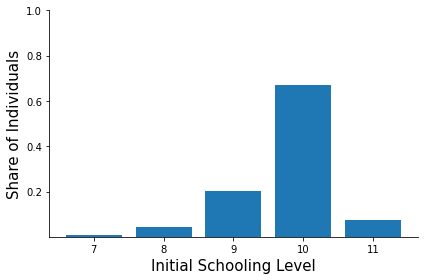

<IPython.core.display.Javascript object>

In [14]:
fig_initial_schooling(get_initial_schooling(df))

In [15]:
def construct_activity_count(agent):
    """Construction of an agent-specific activity count.
    """

    agent["Count White"] = (agent["Choice"] == "white_collar").sum()
    agent["Count Blue"] = (agent["Choice"] == "blue_collar").sum()
    agent["Count School"] = (agent["Choice"] == "schooling").sum()
    agent["Count Home"] = (agent["Choice"] == "home").sum()
    agent["Count Military"] = (agent["Choice"] == "military").sum()  ## new
    agent["Count Total"] = len(agent)

    return agent

<IPython.core.display.Javascript object>

In [16]:
initial_schooling_activity = {}
counted_activities = df.groupby("Identifier", axis=0).apply(construct_activity_count)

for year in get_initial_schooling(df)["years"]:
    cond = df["schooling_experience"].loc[:] == year

    stats = []
    for label in ["Blue", "White", "Military", "School", "Home", "Total"]:  ## new
        stats += [counted_activities["Count " + label][cond].mean()]

    initial_schooling_activity[f"{year}"] = stats

<IPython.core.display.Javascript object>

In [17]:
df_initial_schooling_activity = pd.DataFrame.from_dict(initial_schooling_activity)
df_initial_schooling_activity.index = [
    ["Blue", "White", "Military", "School", "Home", "Total"]
]
df_initial_schooling_activity

,7,8,9,10,11
Blue,4.15,4.18,4.06,3.15,3.19
White,0.10,0.27,0.54,1.03,1.21
Military,0.02,0.11,0.35,0.51,0.68
School,0.12,0.29,1.00,2.35,2.56
Home,5.00,4.50,3.21,2.11,1.58
Total,9.39,9.36,9.17,9.16,9.23


<IPython.core.display.Javascript object>

### Transition Matrix
---

We will illustrate two directions of transition probabilities:
- `origin_to_destination`  
Percentage of individuals who are in an originating alternative in $t$ (column) and will be in a destination alternative in $t+1$ (row). 
    * *Example 1:* 64% of the time, an individual who is in school currently, will be in the school the next year.   
    * *Example 2:* 10% of the time, an individual who is in a blue-collar occupation currently, will be in a white-collar occupation next year.   


- `destination_from_origin`   
Percentage of individual who are in a destinating alternative in $t$ (column) and were in a certain originating alternative in $t-1$ (row).
    * *Example 1:* 87% of the time, an individual who is in school at $t$ was also in school in $t-1$.
    * *Example 1:* 18% of the time, an individual who is employed in a white-collar occupation at $t$ worked in a blue-collar occupation in $t-1$.
   

In [18]:
label_order = ["blue_collar", "white_collar", "military", "schooling", "home"]

<IPython.core.display.Javascript object>

In [19]:
def make_transition_matrix(df):
    """Calculation of transition matrix
    
    Parameters:
    -----------
        df: pd.DataFrame
            DataFrame with unique Identifier (agent) containing the choice for each model period.
    
    Returns:
    --------
        transition_matrix: dict
            Dictionary of transition matrices for both directions.
    
    """

    df["Choice_t_minus_one"] = (
        df["Choice"].groupby("Identifier").apply(lambda x: x.shift(1))
    )
    df["Choice_t_plus_one"] = (
        df["Choice"].groupby("Identifier").apply(lambda x: x.shift(-1))
    )

    transition_matrix = {}
    row_order = label_order
    col_order = label_order
    _relevant_choice = {
        "origin_to_destination": "Choice_t_minus_one",
        "destination_from_origin": "Choice_t_plus_one",
    }

    # Origin to destination (t -> t+1)
    # Corresponding to upper cell entry in KW97, p.487, Table 2

    # Destination from origin (t <- t-1)
    # Percentage in t who started from t-1
    # Corresponding to lower cell entry in KW97, p.487, Table 2

    for transition_direction in ["origin_to_destination", "destination_from_origin"]:
        transition_matrix[f"{transition_direction}"] = pd.crosstab(
            index=df[_relevant_choice[f"{transition_direction}"]],
            columns=df["Choice"],
            normalize="index",
        ).round(4)

        transition_matrix[f"{transition_direction}"] = (
            transition_matrix[f"{transition_direction}"]
            .loc[row_order, col_order]
            .round(2)
        )

    return transition_matrix

<IPython.core.display.Javascript object>

In [24]:
def fig_transition_heatmap(tm, transition_direction="origin_to_destination"):
    """Illustration of transition probability (od and do) in a heatmap.
    
    Parameters:
    -----------
        tm: dictionary
            Dictionary of transition matrices for both directions.
            
        transition_direction: str
            Direction for which the heatmap should be plotted (for subsetting purpose).
    
    
    Returns:
    -------
        plt.savefig
    
    """

    # Refactor the transition_matrix
    tm = tm[transition_direction]
    tm = tm.reindex(label_order[::-1])

    heatmap = sns.heatmap(
        tm,
        cmap="Blues",
        annot=True,
        vmin=0,
        vmax=0.75,
        xticklabels=["Blue", "White", "Military", "Schooling", "Home"],
        yticklabels=["Home", "Schooling", "Military", "White", "Blue"],
    )

    # yticklabels do not match with the data!
    plt.yticks(rotation=0)
    plt.ylabel("Choice $t$", labelpad=10)
    plt.xlabel("Choice $t+1$", labelpad=10)

    plt.savefig(f"./material/fig-heatmap-{transition_direction}.pdf", dpi=300)

<IPython.core.display.Javascript object>

In [25]:
tm_od = make_transition_matrix(df)["origin_to_destination"]
tm_od.columns, tm_od.index = (
    [label.split("_")[0].capitalize() for label in list(tm_od.columns)],
    [label.split("_")[0].capitalize() for label in list(tm_od.index)],
)
tm_od

,Blue,White,Military,Schooling,Home
Blue,0.73,0.10,0.01,0.03,0.12
White,0.20,0.67,0.01,0.06,0.06
Military,0.10,0.03,0.80,0.01,0.06
Schooling,0.12,0.09,0.02,0.64,0.13
Home,0.31,0.08,0.04,0.10,0.47


<IPython.core.display.Javascript object>

In [26]:
tm_do = make_transition_matrix(df)["destination_from_origin"]
tm_do.columns, tm_do.index = (
    [label.split("_")[0].capitalize() for label in list(tm_do.columns)],
    [label.split("_")[0].capitalize() for label in list(tm_do.index)],
)
tm_do

,Blue,White,Military,Schooling,Home
Blue,0.62,0.07,0.02,0.13,0.16
White,0.18,0.52,0.01,0.20,0.09
Military,0.04,0.01,0.73,0.11,0.11
Schooling,0.04,0.03,0.00,0.87,0.06
Home,0.20,0.04,0.02,0.27,0.46


<IPython.core.display.Javascript object>

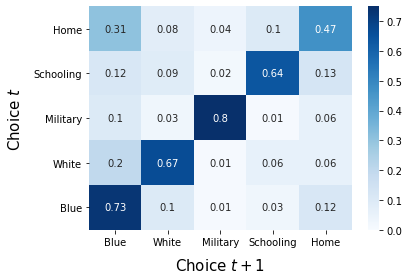

<IPython.core.display.Javascript object>

In [27]:
fig_transition_heatmap(make_transition_matrix(df))